<a href="https://colab.research.google.com/github/aromanenko/ATSF/blob/wip/hw3_solution_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Judging by my evaluation, this one should beat the 2nd AND 1st baselines

Added some features, including business-based ones + tried various HistGrad models, as well as RandomForest, ended up going forward with XGBoost. Will probably try to reach a more elegant solution (for fun) over the weekends, as well as try out LightGBM - we'll see how it goes!

The model adds rolling and static features (I added some on top of the ones from the original notebook), uses a standard scaler, after which it applies PCA with kept variance=0.95 (inputed via CV) and then runs XGBoost (hyperparams selected using CV). Following that, a business-based guess is constructed. A blend of 70% ML, 30% Business was empirically found to be the most optimal (Believe me, I've checked, at least the percentages that can be divided by 10. Weirdly enough, with RandomForest the best blend was 20%:80%). Things that haven't been purchased in over two weeks are then cut from the data, and the negative guesses are converted to their absolute values.

# import libs

In [574]:
!pip3 install numpy matplotlib pandas scikit-learn plotly

41829.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [575]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
# %matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"

# upload and investigate data

In [576]:
all_data = pd.read_csv('train.csv', delimiter=',')

# connvert date-column to data format
all_data['period_start_dt'] = pd.to_datetime(all_data['period_start_dt'], format= "%Y-%m-%d")
all_data.head()

,Unnamed: 0,product_rk,store_location_rk,period_start_dt,demand,...,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG
0,0,40369,309,2016-12-19,29.0,...,NaN,NaN,NaN,NaN,NaN
1,1,40370,309,2016-12-19,64.0,...,NaN,NaN,NaN,NaN,NaN
2,2,40372,309,2016-12-19,32.0,...,NaN,NaN,NaN,NaN,NaN
3,3,40373,309,2016-12-19,10.0,...,NaN,NaN,NaN,NaN,NaN
4,4,46272,309,2016-12-19,15.0,...,NaN,NaN,NaN,NaN,NaN


In [577]:
# rename "Unnamed: 0" to id (it's needed to manage train/and)
all_data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
all_data

,id,product_rk,store_location_rk,period_start_dt,demand,...,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG
0,0,40369,309,2016-12-19,29.0,...,NaN,NaN,NaN,NaN,NaN
1,1,40370,309,2016-12-19,64.0,...,NaN,NaN,NaN,NaN,NaN
2,2,40372,309,2016-12-19,32.0,...,NaN,NaN,NaN,NaN,NaN
3,3,40373,309,2016-12-19,10.0,...,NaN,NaN,NaN,NaN,NaN
4,4,46272,309,2016-12-19,15.0,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
35339,35537,40370,1380,2019-12-30,NaN,...,0.0,1000.00,1000.0,0.0,1.0
35340,35538,40372,1380,2019-12-30,NaN,...,0.0,2000.00,2000.0,0.0,1.0
35341,35539,40373,1380,2019-12-30,NaN,...,0.0,3000.00,3000.0,0.0,1.0
35342,35540,46272,1380,2019-12-30,NaN,...,0.0,284.29,199.0,0.0,1.0


In [578]:
# investigate data holiscitly
all_data.describe()

,id,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG
count,35344.000000,35344.000000,35344.000000,35344,34144.000000,35159.000000,35159.0,34217.000000,34212.000000,35159.0,35159.000000
mean,17766.554012,49253.732232,844.240154,2018-07-24 16:17:19.746491904,12.245636,0.206434,0.0,1167.679357,1155.778351,0.0,0.907677
min,0.000000,40369.000000,309.000000,2016-12-19 00:00:00,0.000000,0.000000,0.0,49.000000,8.647059,0.0,0.000000
25%,8881.750000,40370.000000,535.000000,2017-11-06 00:00:00,2.000000,0.000000,0.0,284.290000,199.000000,0.0,1.000000
50%,17770.500000,40372.000000,862.000000,2018-07-30 00:00:00,6.000000,0.000000,0.0,1000.000000,1000.000000,0.0,1.000000
75%,26647.250000,46272.000000,1173.000000,2019-04-22 00:00:00,12.000000,0.000000,0.0,2000.000000,2000.000000,0.0,1.000000
max,35541.000000,96212.000000,1380.000000,2019-12-30 00:00:00,1160.000000,2.000000,0.0,3000.000000,3000.000000,0.0,1.000000
std,10258.040738,19145.064867,333.229160,NaN,32.604642,0.433393,0.0,1046.828551,1057.912830,0.0,0.289486


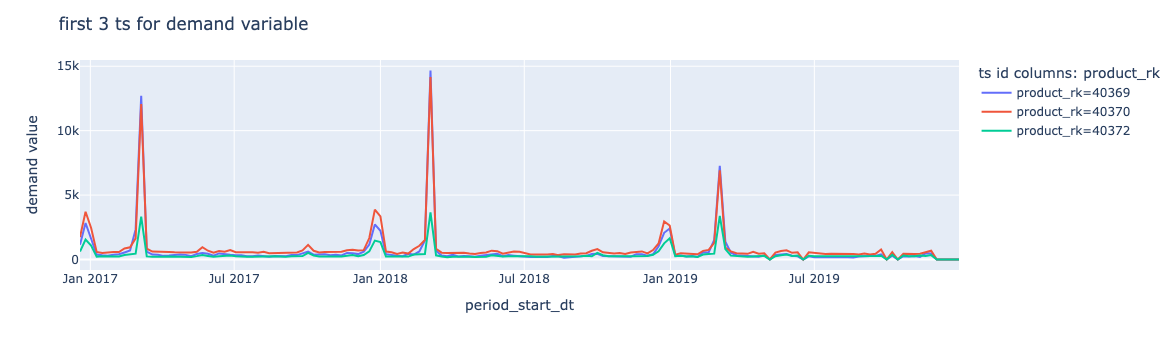

In [579]:
# draw some time series
def plot_some_ts(ts_df, groupby_columns, time_column, target_column, ts_num = 10, aggregation_method = 'sum'):
  '''pivot original ts by group_columns
     ts_df - original dataframe with ts data,
     group_columns - tuple with names of columns used to split data to time series, use None if splitting is not needed
     time_column - name of column with date, datetime64
     target_column - column with ts data (data should be in numerical format), string
     ts_num - number of ts to be drawn, int
     aggregation_method - aggregation method of data in target column, string
  '''

  if groupby_columns is None:
    ts_df[target_column + time_column + 'const'] = 1
    groupby_columns = [target_column + time_column + 'const']

  pivot_ts = ts_df.groupby(groupby_columns + [time_column]).agg(aggregation_method)

  # concat multiple index to single column
  index_column_name = ', '.join([groupby_columns[i]+'={0['+str(i)+']}' for i in range(len(groupby_columns))])
  pivot_ts.index = [pivot_ts.index.map(index_column_name.format) , pivot_ts.index.get_level_values(len(groupby_columns))]

  # unstack by-column (column that contains ts name)
  pivot_ts = pivot_ts.unstack([0])[target_column]

  # plot first ts_num ts
  fig = pivot_ts[pivot_ts.columns[:ts_num]].plot().update_layout(height=350, width=1300,
                                                  title="first {0} ts for {1} variable".format(ts_num, target_column ),
    xaxis_title=time_column,
    yaxis_title=target_column+ ' value',
    legend_title='ts id columns: '+', '.join(groupby_columns)).show()
  return fig

# data for 3 products (all stores-product level)
plot_some_ts(all_data, ['product_rk'], 'period_start_dt', 'demand', ts_num = 3)

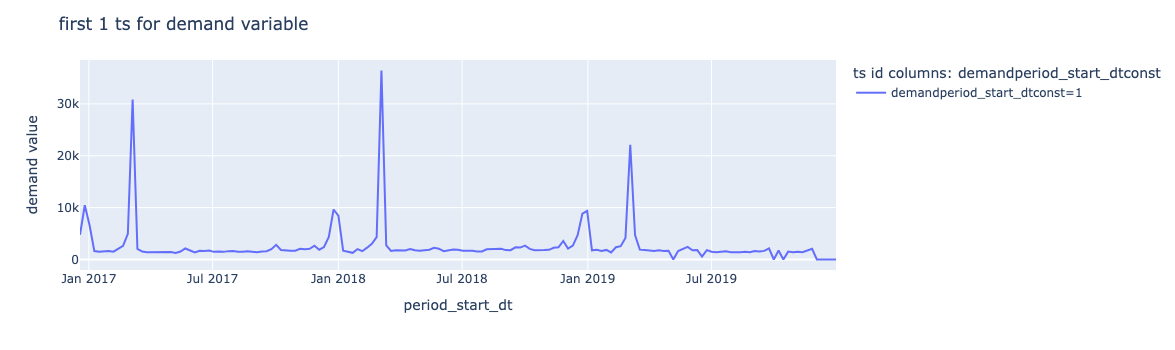

In [580]:
# all stores - all products level
# pay attention to forecasting periods: since 2Dec2019
plot_some_ts(all_data, None, 'period_start_dt', 'demand', ts_num = 1)

# what data dependencies can you observe?

In [581]:
# investigate demand driver columns (explanatory variables )
print(all_data['PROMO1_FLAG'].unique())
print(all_data['PROMO2_FLAG'].unique()) #не используем данную переменную, т.к. значения только 0 и NaN
print(all_data['NUM_CONSULTANT'].unique()) #не используем данную переменную, т.к. значения только 0 и NaN
print(all_data['AUTORIZATION_FLAG'].unique())

[nan  1.  0.  2.]
[nan  0.]
[nan  0.]
[nan  1.  0.]


In [582]:
# remove those, which have only one unique value (not empty) (they do not provide any benefit when training the model)
del all_data['PROMO2_FLAG']
del all_data['NUM_CONSULTANT']
all_data

,id,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demandperiod_start_dtconst
0,0,40369,309,2016-12-19,29.0,NaN,NaN,NaN,NaN,1
1,1,40370,309,2016-12-19,64.0,NaN,NaN,NaN,NaN,1
2,2,40372,309,2016-12-19,32.0,NaN,NaN,NaN,NaN,1
3,3,40373,309,2016-12-19,10.0,NaN,NaN,NaN,NaN,1
4,4,46272,309,2016-12-19,15.0,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...
35339,35537,40370,1380,2019-12-30,NaN,0.0,1000.00,1000.0,1.0,1
35340,35538,40372,1380,2019-12-30,NaN,0.0,2000.00,2000.0,1.0,1
35341,35539,40373,1380,2019-12-30,NaN,0.0,3000.00,3000.0,1.0,1
35342,35540,46272,1380,2019-12-30,NaN,1.0,284.29,199.0,1.0,1


# data preprocessing

## fill missing values based on expert insights

In [583]:
# fill na in PROMO1_FLAG with mode-value (based on common-sense)
all_data['PROMO1_FLAG'] = all_data['PROMO1_FLAG'].fillna(all_data['PROMO1_FLAG'].mode()[0]) # most frequent value
all_data

,id,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demandperiod_start_dtconst
0,0,40369,309,2016-12-19,29.0,0.0,NaN,NaN,NaN,1
1,1,40370,309,2016-12-19,64.0,0.0,NaN,NaN,NaN,1
2,2,40372,309,2016-12-19,32.0,0.0,NaN,NaN,NaN,1
3,3,40373,309,2016-12-19,10.0,0.0,NaN,NaN,NaN,1
4,4,46272,309,2016-12-19,15.0,0.0,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...
35339,35537,40370,1380,2019-12-30,NaN,0.0,1000.00,1000.0,1.0,1
35340,35538,40372,1380,2019-12-30,NaN,0.0,2000.00,2000.0,1.0,1
35341,35539,40373,1380,2019-12-30,NaN,0.0,3000.00,3000.0,1.0,1
35342,35540,46272,1380,2019-12-30,NaN,1.0,284.29,199.0,1.0,1


## fill missing values with prev/back info

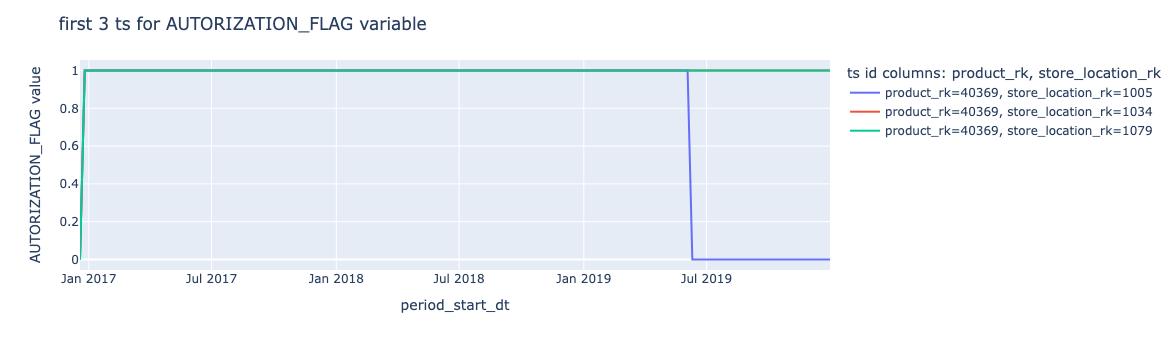

In [584]:
# AUTORIZATION_FLAG - is product available at store at the moment
plot_some_ts(all_data, ['product_rk', 'store_location_rk'], 'period_start_dt', 'AUTORIZATION_FLAG', ts_num = 3)

In [585]:
# filling withh prev then next value in pandas
all_data.set_index(['product_rk', 'store_location_rk', 'period_start_dt'])\
  .unstack([0,1])\
   ['PRICE_REGULAR'].\
   ffill().bfill().\
   stack([1,0], future_stack=True)\
   .rename('REGULAR_PRICE_FIXED')

period_start_dt  store_location_rk  product_rk
2016-12-19       309                40369             NaN
                                    40370             NaN
                                    40372             NaN
                                    40373             NaN
                                    46272             NaN
                                                   ...   
2019-12-30       1380               40370         1000.00
                                    40372         2000.00
                                    40373         3000.00
                                    96212          141.43
                                    46272          284.29
Name: REGULAR_PRICE_FIXED, Length: 38955, dtype: float64

In [586]:
# fill na with prev (and if no prev then next) values
all_data = all_data.set_index(['product_rk', 'store_location_rk', 'period_start_dt']).\
  merge( all_data.set_index(['product_rk', 'store_location_rk', 'period_start_dt'])\
            .unstack([0,1])\
            ['PRICE_REGULAR'].\
              ffill().bfill().\
            stack([1,0],  future_stack=True).\
            rename('PRICE_REGULAR_FIXED'),
         how = 'left', right_index = True, left_index = True)\
  .reset_index()

# dell original column and replace with new one
del all_data['PRICE_REGULAR']
all_data.rename(columns = {'PRICE_REGULAR_FIXED':'PRICE_REGULAR'}, inplace=True)
all_data.head()

,product_rk,store_location_rk,period_start_dt,id,demand,PROMO1_FLAG,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demandperiod_start_dtconst,PRICE_REGULAR
0,40369,309,2016-12-19,0,29.0,0.0,NaN,NaN,1,NaN
1,40370,309,2016-12-19,1,64.0,0.0,NaN,NaN,1,NaN
2,40372,309,2016-12-19,2,32.0,0.0,NaN,NaN,1,NaN
3,40373,309,2016-12-19,3,10.0,0.0,NaN,NaN,1,NaN
4,46272,309,2016-12-19,4,15.0,0.0,NaN,NaN,1,NaN


In [587]:
def ts_fillna_ffill_bfill(ts_df,column_name, ts_id):
#  all_data.set_index(['product_rk', 'store_location_rk', 'period_start_dt'])\ # define id columns
#   .unstack([0,1])\                          # df -> pivot transformation: date column - is row-index, product x store - is column index
#   ['PRICE_REGULAR'].\                      # define column with data to be fixed
#   ffill().bfill().\                        # fill missing value: apply forwand then back filling method consequently
#   stack([1,0]).\                           # pivot -> ts transformation
#   rename('REGULAR_PRICE_FIXED')            # rename column


  # fill na with prev (and if no prev then next) values
  new_ts_df = ts_df.set_index(ts_id).\
    merge(ts_df.set_index(ts_id)\
              .unstack([0,1])\
              [column_name].\
              ffill().bfill().\
              stack([1,0],  future_stack=True).\
              rename(column_name),
          how = 'left', right_index = True, left_index = True)\
    .reset_index()

  # dell original column and replace with new one
  del new_ts_df[column_name+'_x']
  return new_ts_df.rename(columns = {column_name+'_y':column_name})

In [588]:
all_data.head()

,product_rk,store_location_rk,period_start_dt,id,demand,PROMO1_FLAG,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demandperiod_start_dtconst,PRICE_REGULAR
0,40369,309,2016-12-19,0,29.0,0.0,NaN,NaN,1,NaN
1,40370,309,2016-12-19,1,64.0,0.0,NaN,NaN,1,NaN
2,40372,309,2016-12-19,2,32.0,0.0,NaN,NaN,1,NaN
3,40373,309,2016-12-19,3,10.0,0.0,NaN,NaN,1,NaN
4,46272,309,2016-12-19,4,15.0,0.0,NaN,NaN,1,NaN


In [589]:
# the same for PRICE_AFTER_DISCOUNT
all_data = ts_fillna_ffill_bfill(
    ts_df=all_data,
    column_name='PRICE_AFTER_DISC',
    ts_id=['product_rk', 'store_location_rk', 'period_start_dt']
)

# the same for AUTORIZATION_FLAG
all_data = ts_fillna_ffill_bfill(
    ts_df=all_data,
    column_name='AUTORIZATION_FLAG',
    ts_id=['product_rk', 'store_location_rk', 'period_start_dt']
)

In [590]:
# look at data again
all_data.head()

,product_rk,store_location_rk,period_start_dt,id,demand,PROMO1_FLAG,demandperiod_start_dtconst,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG
0,40369,309,2016-12-19,0,29.0,0.0,1,NaN,NaN,NaN
1,40370,309,2016-12-19,1,64.0,0.0,1,NaN,NaN,NaN
2,40372,309,2016-12-19,2,32.0,0.0,1,NaN,NaN,NaN
3,40373,309,2016-12-19,3,10.0,0.0,1,NaN,NaN,NaN
4,46272,309,2016-12-19,4,15.0,0.0,1,NaN,NaN,NaN


## fill missing values as average/mode/median from other stores

In [591]:
# find mean values for each pair product x date
values = all_data.set_index(['product_rk', 'period_start_dt', 'store_location_rk'])\
            .unstack([0,1])\
            ['PRICE_REGULAR'].\
              mean()

# replace missing values with mean in all stores
all_data.set_index(['product_rk', 'store_location_rk', 'period_start_dt'])\
            .unstack([0,2])\
            ['PRICE_REGULAR'].\
            fillna(value = values).\
            stack([1,0], future_stack=True).\
            rename('REGULAR_PRICE_FIXED')

store_location_rk  period_start_dt  product_rk
309                2016-12-19       40369          500.00
                                    40370         1000.00
                                    40372         2000.00
                                    40373         3000.00
                                    46272          157.00
                                                   ...   
1380               2019-12-30       40372         2000.00
                                    40373         3000.00
                                    46272          284.29
                                    96212          141.43
                   2017-07-17       96212           79.00
Name: REGULAR_PRICE_FIXED, Length: 37884, dtype: float64

In [592]:
def ts_fillna_aggmethod(ts_df,column_name, ts_id):
#  all_data.set_index(['product_rk', 'store_location_rk', 'period_start_dt'])\ # define id columns
#   .unstack([0,1])\                          # df -> pivot transformation: date column - is row-index, product x store - is column index
#   ['PRICE_REGULAR'].\                      # define column with data to be fixed
#   ffill().bfill().\                        # fill missing value: apply forwand then back filling method consequently
#   stack([1,0]).\                           # pivot -> ts transformation
#   rename('REGULAR_PRICE_FIXED')            # rename column

  values = all_data.set_index(ts_id)\
            .unstack([0,1])\
            [column_name].\
              mean()

  # fill na with prev (and if no prev then next) values
  new_ts_df = ts_df.set_index(ts_id).\
    merge(ts_df.set_index(ts_id)\
              .unstack([0,1])\
              [column_name].\
              fillna(value = values).\
              stack([1,0], future_stack=True).\
              rename(column_name),
          how = 'left', right_index = True, left_index = True)\
    .reset_index()

  # dell original column and replace with new one
  del new_ts_df[column_name+'_x']
  return new_ts_df.rename(columns = {column_name+'_y':column_name})


# for PRICE_REGULAR
all_data = ts_fillna_aggmethod(
    ts_df=all_data,
    column_name='PRICE_REGULAR',
    ts_id=['product_rk', 'period_start_dt', 'store_location_rk']
)

In [593]:
# the same for PRICE_AFTER_DISCOUNT
all_data = ts_fillna_aggmethod(
    ts_df=all_data,
    column_name='PRICE_AFTER_DISC',
    ts_id=['product_rk', 'period_start_dt', 'store_location_rk']
)

# the same for AUTORIZATION_FLAG
all_data = ts_fillna_aggmethod(
    ts_df=all_data,
    column_name='AUTORIZATION_FLAG',
    ts_id=['product_rk', 'period_start_dt', 'store_location_rk']
)

In [594]:
# check data again
all_data.isna().sum()

product_rk                       0
period_start_dt                  0
store_location_rk                0
id                               0
demand                        1200
PROMO1_FLAG                      0
demandperiod_start_dtconst       0
PRICE_REGULAR                    0
PRICE_AFTER_DISC                 0
AUTORIZATION_FLAG                0
dtype: int64

In [595]:
# let's delete store 309 related data
all_data = all_data[all_data['store_location_rk'] != 309]
all_data

,product_rk,period_start_dt,store_location_rk,id,demand,PROMO1_FLAG,demandperiod_start_dtconst,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG
15,40369,2016-12-19,317,15,50.0,0.0,1,500.00,500.0,1.0
16,40370,2016-12-19,317,16,44.0,0.0,1,1000.00,1000.0,1.0
17,40372,2016-12-19,317,17,13.0,0.0,1,2000.00,2000.0,1.0
18,40373,2016-12-19,317,18,6.0,0.0,1,3000.00,3000.0,1.0
19,46272,2016-12-19,317,19,34.0,0.0,1,157.00,157.0,1.0
...,...,...,...,...,...,...,...,...,...,...
35339,40370,2019-12-30,1380,35537,NaN,0.0,1,1000.00,1000.0,1.0
35340,40372,2019-12-30,1380,35538,NaN,0.0,1,2000.00,2000.0,1.0
35341,40373,2019-12-30,1380,35539,NaN,0.0,1,3000.00,3000.0,1.0
35342,46272,2019-12-30,1380,35540,NaN,1.0,1,284.29,199.0,1.0


In [596]:
# check data again
# that's it
all_data.isna().sum()

product_rk                       0
period_start_dt                  0
store_location_rk                0
id                               0
demand                        1200
PROMO1_FLAG                      0
demandperiod_start_dtconst       0
PRICE_REGULAR                    0
PRICE_AFTER_DISC                 0
AUTORIZATION_FLAG                0
dtype: int64

## add calendar-feature

In [597]:
all_data["ind_of_year"] = [dt.year for dt in all_data.period_start_dt]
all_data["ind_of_month"] = [dt.month for dt in all_data.period_start_dt]
all_data["ind_of_day"] = [dt.day for dt in all_data.period_start_dt]
all_data.head()

,product_rk,period_start_dt,store_location_rk,id,demand,...,PRICE_AFTER_DISC,AUTORIZATION_FLAG,ind_of_year,ind_of_month,ind_of_day
15,40369,2016-12-19,317,15,50.0,...,500.0,1.0,2016,12,19
16,40370,2016-12-19,317,16,44.0,...,1000.0,1.0,2016,12,19
17,40372,2016-12-19,317,17,13.0,...,2000.0,1.0,2016,12,19
18,40373,2016-12-19,317,18,6.0,...,3000.0,1.0,2016,12,19
19,46272,2016-12-19,317,19,34.0,...,157.0,1.0,2016,12,19


In [598]:
# сортируем данные по ключам ряда
all_data = all_data.sort_values(['product_rk', 'store_location_rk', 'period_start_dt'])

# ---- ручные лаги спроса ----
for lag in [1, 2, 3, 4, 7, 14, 28, 52]:
    all_data[f'demand_lag_{lag}'] = (
        all_data
        .groupby(['product_rk', 'store_location_rk'])['demand']
        .shift(lag)
    )

# ---- скользящие средние по спросу ----
for window in [4, 8, 12, 26]:
    all_data[f'demand_roll_mean_{window}'] = (
        all_data
        .groupby(['product_rk', 'store_location_rk'], group_keys=False)['demand']
        .apply(lambda s: s.shift(1).rolling(window, min_periods=1).mean())
    )

# ---- промо/ценовые фичи ----
all_data['discount_abs'] = all_data['PRICE_REGULAR'] - all_data['PRICE_AFTER_DISC']
all_data['discount_rel'] = all_data['discount_abs'] / all_data['PRICE_REGULAR']
all_data['discount_rel'] = all_data['discount_rel'].replace([np.inf, -np.inf], 0).fillna(0)

all_data['is_promo'] = (all_data['PRICE_AFTER_DISC'] < all_data['PRICE_REGULAR']).astype(int)

# лаг промо на 1 период
all_data['is_promo_lag_1'] = (
    all_data
    .groupby(['product_rk', 'store_location_rk'])['is_promo']
    .shift(1)
)
all_data['is_promo_lag_1'] = all_data['is_promo_lag_1'].fillna(0)


In [599]:
# финальная чистка признаков после всех фич
all_data = all_data.replace([np.inf, -np.inf], np.nan)

feature_cols = [c for c in all_data.columns
                if c not in ['id', 'demand', 'period_start_dt']]

all_data[feature_cols] = all_data[feature_cols].fillna(0)


# train ML model

## Adding more features

In [600]:
from copy import deepcopy
from ipywidgets import IntProgress
from itertools import product

import numpy as np
import pandas as pd


def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_


# add missing dates to GroupBy.Core object
def fill_missing_dates(x, date_col, freq=None, default_value=np.nan):
    if freq is None:
        try:
            freq = pd.infer_freq(
                x.set_index(date_col).index[:min(100, x.shape[0])]
            )
        except:
            freq = 'D'

        if freq is None:
            freq = 'D'
            Warning('TS freq is not defined! Daily granularity is provided!')

    idx = pd.date_range(x[date_col].min(), x[date_col].max(), freq=freq)
    res = x.set_index(date_col).reindex(idx, fill_value=default_value)
    res.index.rename(date_col, inplace=True)
    return res.reset_index()


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
    data_preag = data.groupby(group_col).agg(preagg_method)[target_cols].reset_index()
    data_preag_filled = data_preag.groupby(group_col[:-1]).apply(
        fill_missing_dates, date_col=date_col
    ).drop(group_col[:-1], axis=1).reset_index()
    return data_preag_filled


def calc_rolling(data_preag_filled, group_col, date_col, method, w):
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).apply(
        lambda x: x.set_index(date_col)
        .rolling(window=w, min_periods=1)
        .agg(method)
    ).drop(group_col[:-1], axis=1).reset_index(group_col)
    return lf_df_filled


def calc_ewm(data_preag_filled, group_col, date_col, span):
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).apply(
        lambda x: x.set_index(date_col).ewm(span=span).mean()
    ).drop(group_col[:-1], axis=1).reset_index(group_col)
    return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag, kwargs=None):
    lf_df = (
        lf_df_filled
        .set_index(date_col)
        .groupby(group_col[:-1])
        .apply(lambda x: x.shift(lag, None))
        .drop(group_col[:-1], axis=1)
        .reset_index()
    )
    return lf_df

In [601]:
def add_static_features(out_df, target_cols, id_cols, date_col):
    """
    here iadd:
    - prod_* (by SKU)
    - store_* (by Store)
    - ps_* (by SKU–Store)
    - calendar + december features
    - last-year december (same week, avg, ratio)
    """
    out_df = out_df.copy()
    t = target_cols[0]
    prod_col = id_cols[0]
    store_col = id_cols[1]

    # calendar
    d = out_df[date_col]
    out_df["year"] = d.dt.year
    out_df["month"] = d.dt.month
    try:
        out_df["weekofyear"] = d.dt.isocalendar().week.astype(int)
    except Exception:
        out_df["weekofyear"] = d.dt.week

    out_df["week_in_december"] = 0
    m_dec = out_df["month"] == 12
    tmp = out_df.loc[m_dec, [date_col, "year"]].copy()
    tmp["week_in_december"] = (
        tmp.groupby("year")[date_col].rank(method="dense").astype(int)
    )
    out_df.loc[tmp.index, "week_in_december"] = tmp["week_in_december"]

    dec = out_df[out_df["month"] == 12]

    # product-level
    g_prod = out_df.groupby(prod_col)[t]
    prod = pd.DataFrame({
        "prod_mean": g_prod.mean(),
        "prod_std": g_prod.std(),
        "prod_cnt": g_prod.count()
    })

    nz_prod = (
        out_df.assign(_nz=(out_df[t] > 0).astype(int))
        .groupby(prod_col)["_nz"]
        .mean()
        .rename("prod_nz_share")
    )
    prod = prod.join(nz_prod, how="left")

    if len(dec) > 0:
        g_prod_dec = dec.groupby(prod_col)[t]
        prod_dec_mean = g_prod_dec.mean().rename("prod_dec_mean")
        prod_dec_nz = (
            dec.assign(_nz=(dec[t] > 0).astype(int))
            .groupby(prod_col)["_nz"]
            .mean()
            .rename("prod_dec_nz_share")
        )
        prod = prod.join(prod_dec_mean, how="left")
        prod = prod.join(prod_dec_nz, how="left")
        prod["prod_dec_ratio"] = (
            prod["prod_dec_mean"] / (prod["prod_mean"] + 1e-6)
        )

    prod["prod_cv"] = prod["prod_std"] / (prod["prod_mean"] + 1e-6)
    prod = prod.reset_index()
    out_df = out_df.merge(prod, on=prod_col, how="left")

    # store-level
    g_store = out_df.groupby(store_col)[t]
    store = pd.DataFrame({
        "store_mean": g_store.mean(),
        "store_std": g_store.std(),
        "store_cnt": g_store.count()
    })

    nz_store = (
        out_df.assign(_nz=(out_df[t] > 0).astype(int))
        .groupby(store_col)["_nz"]
        .mean()
        .rename("store_nz_share")
    )
    store = store.join(nz_store, how="left")

    if len(dec) > 0:
        g_store_dec = dec.groupby(store_col)[t]
        store_dec_mean = g_store_dec.mean().rename("store_dec_mean")
        store_dec_nz = (
            dec.assign(_nz=(dec[t] > 0).astype(int))
            .groupby(store_col)["_nz"]
            .mean()
            .rename("store_dec_nz_share")
        )
        store = store.join(store_dec_mean, how="left")
        store = store.join(store_dec_nz, how="left")
        store["store_dec_ratio"] = (
            store["store_dec_mean"] / (store["store_mean"] + 1e-6)
        )

    store["store_cv"] = store["store_std"] / (store["store_mean"] + 1e-6)
    store = store.reset_index()
    out_df = out_df.merge(store, on=store_col, how="left")

    # SKU–store pair
    key_ps = [prod_col, store_col]
    g_ps = out_df.groupby(key_ps)[t]
    ps = pd.DataFrame({
        "ps_mean": g_ps.mean(),
        "ps_std": g_ps.std(),
        "ps_cnt": g_ps.count()
    })

    nz_ps = (
        out_df.assign(_nz=(out_df[t] > 0).astype(int))
        .groupby(key_ps)["_nz"]
        .mean()
        .rename("ps_nz_share")
    )
    ps = ps.join(nz_ps, how="left")

    if len(dec) > 0:
        g_ps_dec = dec.groupby(key_ps)[t]
        ps_dec_mean = g_ps_dec.mean().rename("ps_dec_mean")
        ps_dec_nz = (
            dec.assign(_nz=(dec[t] > 0).astype(int))
            .groupby(key_ps)["_nz"]
            .mean()
            .rename("ps_dec_nz_share")
        )
        ps = ps.join(ps_dec_mean, how="left")
        ps = ps.join(ps_dec_nz, how="left")
        ps["ps_dec_ratio"] = ps["ps_dec_mean"] / (ps["ps_mean"] + 1e-6)

    ps["ps_cv"] = ps["ps_std"] / (ps["ps_mean"] + 1e-6)
    ps = ps.reset_index()
    out_df = out_df.merge(ps, on=key_ps, how="left")

    # last-year dec by week
    if len(dec) > 0:
        dec_all = out_df[out_df["month"] == 12].copy()
        # year-level avg
        dec_year = (
            dec_all
            .groupby(key_ps + ["year"])[t]
            .mean()
            .rename("dec_mean_year")
            .reset_index()
        )

        # week-level
        dec_week = (
            dec_all
            .groupby(key_ps + ["year", "week_in_december"])[t]
            .mean()
            .rename("demand_dec_week")
            .reset_index()
        )

        dec_week = dec_week.merge(
            dec_year,
            on=key_ps + ["year"],
            how="left"
        )

        dec_week["year"] = dec_week["year"] + 1
        dec_week["demand_last_year_same_week"] = dec_week["demand_dec_week"]
        dec_week["dec_last_year_avg"] = dec_week["dec_mean_year"]
        dec_week["week_ratio_last_year"] = (
            dec_week["demand_last_year_same_week"]
            / (dec_week["dec_last_year_avg"] + 1e-6)
        )

        dec_week = dec_week[
            key_ps
            + ["year", "week_in_december",
               "demand_last_year_same_week",
               "dec_last_year_avg",
               "week_ratio_last_year"]
        ]

        out_df = out_df.merge(
            dec_week,
            on=key_ps + ["year", "week_in_december"],
            how="left"
        )

    return out_df

In [602]:
def generate_lagged_features(
        data: pd.DataFrame,
        target_cols: list = ['Demand'],
        id_cols: list = ['SKU_id', 'Store_id'],
        date_col: str = 'Date',
        lags: list = [7, 14, 21, 28],
        windows: list = ['7D', '14D', '28D', '56D'],
        preagg_methods: list = ['mean'],
        agg_methods: list = ['mean', 'median', percentile(10), pd.Series.skew],
        dynamic_filters: list = ['weekday', 'Promo'],
        ewm_params: dict = {'weekday': [14, 28], 'Promo': [14, 42]}
) -> pd.DataFrame:

    '''
    data - dataframe with default index
    target_cols - column names for lags calculation
    id_cols - key columns to identify unique values
    date_col - column with datetime format values
    lags - lag values(days)
    windows - windows(days/weeks/months/etc.),
        calculation is performed within time range length of window
    preagg_methods - applied methods before rolling to make
        every value unique for given id_cols
    agg_methods - method of aggregation('mean', 'median', percentile, etc.)
    dynamic_filters - column names to use as filter
    ewm_params - span values(days) for each dynamic_filter
    '''

    data = data.sort_values(date_col)
    out_df = deepcopy(data)

    out_df[date_col] = pd.to_datetime(out_df[date_col])
    out_df = add_static_features(out_df, target_cols, id_cols, date_col)

    # drop level_* created by groupby.apply
    bad_cols = [c for c in out_df.columns if str(c).startswith('level_')]
    if bad_cols:
        out_df = out_df.drop(columns=bad_cols)

    total = (
        len(target_cols)
        * len(lags)
        * len(windows)
        * len(preagg_methods)
        * len(agg_methods)
        * len(dynamic_filters)
    )
    progress = IntProgress(min=0, max=total)
    display(progress)

    for filter_col in dynamic_filters:
        group_col = [filter_col] + id_cols + [date_col]

        for preagg in preagg_methods:
            data_preag_filled = calc_preag_fill(
                out_df, group_col, date_col, target_cols, preagg
            )

            bad_cols = [c for c in data_preag_filled.columns
                        if str(c).startswith('level_')]
            if bad_cols:
                data_preag_filled = data_preag_filled.drop(columns=bad_cols)

            for alpha in ewm_params.get(filter_col, []):
                ewm_filled = calc_ewm(
                    data_preag_filled, group_col, date_col, alpha
                )

                bad_cols = [c for c in ewm_filled.columns
                            if str(c).startswith('level_')]
                if bad_cols:
                    ewm_filled = ewm_filled.drop(columns=bad_cols)

                for lag in lags:
                    ewm = shift(ewm_filled, group_col, date_col, lag)
                    keep_cols = [c for c in ewm.columns
                                 if (c in group_col) or (c in target_cols)]
                    ewm = ewm[keep_cols]

                    new_names = {
                        x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".format(
                            x, lag, alpha, '&'.join(id_cols), preagg, filter_col
                        )
                        for x in target_cols
                    }

                    out_df = pd.merge(
                        out_df,
                        ewm.rename(columns=new_names),
                        how='left',
                        on=group_col
                    )

            for w in windows:
                for method in agg_methods:
                    rolling_filled = calc_rolling(
                        data_preag_filled, group_col, date_col, method, w
                    )

                    bad_cols = [c for c in rolling_filled.columns
                                if str(c).startswith('level_')]
                    if bad_cols:
                        rolling_filled = rolling_filled.drop(columns=bad_cols)

                    for lag in lags:
                        rolling = shift(
                            rolling_filled, group_col, date_col, lag
                        )

                        keep_cols = [c for c in rolling.columns
                                     if (c in group_col) or (c in target_cols)]
                        rolling = rolling[keep_cols]

                        method_name = (
                            method.__name__
                            if isinstance(method, str) is False else method
                        )

                        new_names = {
                            x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".format(
                                x, lag, w, '&'.join(id_cols), preagg,
                                method_name, filter_col
                            )
                            for x in target_cols
                        }

                        out_df = pd.merge(
                            out_df,
                            rolling.rename(columns=new_names),
                            how='left',
                            on=group_col
                        )
                        progress.value += 1

    return out_df


In [603]:
target_cols = ['demand']
id_cols = ['product_rk', 'store_location_rk']
date_col = 'period_start_dt'
built_in_funcs = [pd.Series.kurtosis, pd.Series.skew]
all_data['NoFilter'] = 1
all_data["period_start_dt"] = pd.to_datetime(all_data["period_start_dt"])


all_data = generate_lagged_features(
    all_data,
    target_cols=target_cols,
    id_cols=id_cols,
    date_col=date_col,
    lags=[7, 14, 21, 28],                    
    windows=['7D', '14D', '28D', '56D'],     
    preagg_methods=['mean'],                 
    agg_methods=['mean', 'median', percentile(10), percentile(90)],
    dynamic_filters=['NoFilter'],
    ewm_params={'NoFilter': [14, 28, 56]}   
)


IntProgress(value=0, max=64)

/var/folders/h2/stzlpqvs5dz_lkpjkhzr0x8c0000gn/T/ipykernel_99662/1486007136.py:39: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/h2/stzlpqvs5dz_lkpjkhzr0x8c0000gn/T/ipykernel_99662/1486007136.py:55: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/h2/stzlpqvs5dz_lkpjkhzr0x8c0000gn/T/ipykernel_99662/1486007136.py:66: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This b

In [604]:
#split train and test data
data_train = all_data[all_data['demand'].isnull() == False]
data_train

,product_rk,period_start_dt,store_location_rk,id,demand,PROMO1_FLAG,demandperiod_start_dtconst,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,...,demand_lag21d_w56D_keyproduct_rk&store_location_rk_preagmean_agmedian_NoFilter_dynamic_rolling,demand_lag28d_w56D_keyproduct_rk&store_location_rk_preagmean_agmedian_NoFilter_dynamic_rolling,demand_lag7d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl10_NoFilter_dynamic_rolling,demand_lag14d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl10_NoFilter_dynamic_rolling,demand_lag21d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl10_NoFilter_dynamic_rolling,demand_lag28d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl10_NoFilter_dynamic_rolling,demand_lag7d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl90_NoFilter_dynamic_rolling,demand_lag14d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl90_NoFilter_dynamic_rolling,demand_lag21d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl90_NoFilter_dynamic_rolling,demand_lag28d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl90_NoFilter_dynamic_rolling
0,40369,2016-12-19,317,15,50.0,0.0,1,500.00,500.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40373,2016-12-19,1080,23222,15.0,0.0,1,3000.00,3000.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40370,2016-12-19,866,18581,30.0,0.0,1,1000.00,1000.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,40373,2016-12-19,1079,22294,4.0,0.0,1,3000.00,3000.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40370,2016-12-19,874,19510,84.0,0.0,1,1000.00,1000.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34124,40373,2019-11-25,557,12036,5.0,0.0,1,3000.00,3000.0,1.0,...,4.5,4.0,3.5,3.7,1.4,2.1,9.2,10.3,7.5,6.9
34125,40372,2019-11-25,866,19469,5.0,0.0,1,2000.00,2000.0,1.0,...,3.5,0.0,0.0,2.1,1.4,0.0,9.9,8.9,7.0,5.2
34126,46272,2019-11-25,562,12966,1.0,1.0,1,284.29,199.0,1.0,...,2.0,0.5,0.0,0.0,0.0,0.0,3.6,4.3,4.6,5.6
34127,40373,2019-11-25,1202,29676,0.0,0.0,1,3000.00,3000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [605]:
data_test = all_data[all_data['demand'].isnull()]
# rename "demand" to "predicted"
data_test.rename(columns={'demand': 'predicted'}, inplace=True)
data_test # 1200 samples

/var/folders/h2/stzlpqvs5dz_lkpjkhzr0x8c0000gn/T/ipykernel_99662/1248893727.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,product_rk,period_start_dt,store_location_rk,id,predicted,PROMO1_FLAG,demandperiod_start_dtconst,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,...,demand_lag21d_w56D_keyproduct_rk&store_location_rk_preagmean_agmedian_NoFilter_dynamic_rolling,demand_lag28d_w56D_keyproduct_rk&store_location_rk_preagmean_agmedian_NoFilter_dynamic_rolling,demand_lag7d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl10_NoFilter_dynamic_rolling,demand_lag14d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl10_NoFilter_dynamic_rolling,demand_lag21d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl10_NoFilter_dynamic_rolling,demand_lag28d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl10_NoFilter_dynamic_rolling,demand_lag7d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl90_NoFilter_dynamic_rolling,demand_lag14d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl90_NoFilter_dynamic_rolling,demand_lag21d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl90_NoFilter_dynamic_rolling,demand_lag28d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl90_NoFilter_dynamic_rolling
34129,40369,2019-12-02,1380,35512,NaN,0.0,1,500.00,500.000000,1.0,...,2.0,2.0,0.0,1.0,0.0,0.0,4.900000,6.3,6.0,4.30
34130,40369,2019-12-02,1281,31531,NaN,0.0,1,500.00,500.000000,1.0,...,14.0,17.5,0.0,6.4,4.9,7.0,18.900000,16.6,21.1,20.30
34131,46272,2019-12-02,637,13901,NaN,1.0,1,284.29,199.000000,1.0,...,5.0,6.5,0.0,1.0,1.7,0.0,2.300000,4.6,8.2,12.32
34132,40373,2019-12-02,504,5553,NaN,0.0,1,3000.00,3000.000000,1.0,...,1.5,3.0,0.0,1.0,0.0,0.7,6.452459,6.0,7.1,4.30
34133,46272,2019-12-02,1203,30605,NaN,1.0,1,284.29,199.000000,1.0,...,3.0,3.0,0.0,0.0,0.7,0.7,6.300000,4.0,6.2,8.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35324,46272,2019-12-30,355,1865,NaN,1.0,1,284.29,199.000000,1.0,...,2.0,4.0,0.0,0.0,1.4,1.4,4.300000,5.6,5.2,6.20
35325,40370,2019-12-30,1202,29704,NaN,0.0,1,1000.00,1000.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00
35326,46272,2019-12-30,317,936,NaN,1.0,1,284.29,161.096667,1.0,...,2.5,1.5,0.0,0.0,0.0,0.0,5.300000,3.0,4.0,7.00
35327,40370,2019-12-30,517,6504,NaN,0.0,1,1000.00,1000.000000,1.0,...,6.5,8.0,0.0,3.0,2.1,0.0,12.100000,14.2,11.4,12.00


In [606]:
X = data_train.drop(['id', 'demand', 'period_start_dt'], axis=1)
y = data_train['demand']

In [607]:
X

,product_rk,store_location_rk,PROMO1_FLAG,demandperiod_start_dtconst,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,ind_of_year,ind_of_month,ind_of_day,...,demand_lag21d_w56D_keyproduct_rk&store_location_rk_preagmean_agmedian_NoFilter_dynamic_rolling,demand_lag28d_w56D_keyproduct_rk&store_location_rk_preagmean_agmedian_NoFilter_dynamic_rolling,demand_lag7d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl10_NoFilter_dynamic_rolling,demand_lag14d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl10_NoFilter_dynamic_rolling,demand_lag21d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl10_NoFilter_dynamic_rolling,demand_lag28d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl10_NoFilter_dynamic_rolling,demand_lag7d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl90_NoFilter_dynamic_rolling,demand_lag14d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl90_NoFilter_dynamic_rolling,demand_lag21d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl90_NoFilter_dynamic_rolling,demand_lag28d_w56D_keyproduct_rk&store_location_rk_preagmean_agpctl90_NoFilter_dynamic_rolling
0,40369,317,0.0,1,500.00,500.0,1.0,2016,12,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40373,1080,0.0,1,3000.00,3000.0,1.0,2016,12,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40370,866,0.0,1,1000.00,1000.0,1.0,2016,12,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,40373,1079,0.0,1,3000.00,3000.0,1.0,2016,12,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40370,874,0.0,1,1000.00,1000.0,1.0,2016,12,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34124,40373,557,0.0,1,3000.00,3000.0,1.0,2019,11,25,...,4.5,4.0,3.5,3.7,1.4,2.1,9.2,10.3,7.5,6.9
34125,40372,866,0.0,1,2000.00,2000.0,1.0,2019,11,25,...,3.5,0.0,0.0,2.1,1.4,0.0,9.9,8.9,7.0,5.2
34126,46272,562,1.0,1,284.29,199.0,1.0,2019,11,25,...,2.0,0.5,0.0,0.0,0.0,0.0,3.6,4.3,4.6,5.6
34127,40373,1202,0.0,1,3000.00,3000.0,0.0,2019,11,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [608]:
# answers in train period
y

0        50.0
1        15.0
2        30.0
3         4.0
4        84.0
         ... 
34124     5.0
34125     5.0
34126     1.0
34127     0.0
34128     2.0
Name: demand, Length: 34129, dtype: float64

In [609]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

In [610]:
# for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [611]:
# i included a "divisor" variable that is large enough for the values to be negligeble enough for the proper functioning of log1p and expm1, as the work properly when 1 = x+1

In [612]:
divisor = max(y_train) * 10

In [613]:
y_train = y_train / divisor

In [614]:
y_train = np.log1p(y_train)

In [615]:
!pip3 install xgboost

41913.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [616]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor  

all_feats = X_train.columns

regressor = Pipeline([
    ("scaler", StandardScaler()),         
    ("pca", PCA(n_components=0.99)),      
    ("model", XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=1.0,
        reg_lambda=1.0,
        objective="reg:squarederror",
        n_jobs=-1,
        random_state=42,
        tree_method="hist"        
    ))
])

regressor.fit(X_train, y_train)

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,0.99
,copy,True
,whiten,False
,svd_solver,'auto'


In [617]:
y_pred = regressor.predict(X_test)
y_pred = np.expm1(y_pred)
y_pred = y_pred * divisor

In [618]:
mean_absolute_error(y_test, y_pred)

5.952340208862013

In [619]:
# score sample from forecasting period
X_test_sub = data_test.drop(['id', 'predicted', 'period_start_dt'], axis=1)

# clear of infs
X_test_sub = X_test_sub.replace([np.inf, -np.inf], np.nan).fillna(0)

In [620]:
y_pred_res = regressor.predict(X_test_sub)
y_pred_res = np.expm1(y_pred_res)
y_pred_res = y_pred_res * divisor

In [621]:
y_results = data_test[['id', 'product_rk', 'store_location_rk', 'period_start_dt']].copy()

In [622]:
y_results

,id,product_rk,store_location_rk,period_start_dt
34129,35512,40369,1380,2019-12-02
34130,31531,40369,1281,2019-12-02
34131,13901,46272,637,2019-12-02
34132,5553,40373,504,2019-12-02
34133,30605,46272,1203,2019-12-02
...,...,...,...,...
35324,1865,46272,355,2019-12-30
35325,29704,40370,1202,2019-12-30
35326,936,46272,317,2019-12-30
35327,6504,40370,517,2019-12-30


# forecast preprocessing + business-informed values

## The ML model on its own isn't quite perfect at guessing, and neither are algorithmic methods. However, a combination of the two yields better results (i checked by hand), hence I'm going to add a data-based guess:

Let's cut the stuff that wasn't bought in the last 2 weeks:

In [623]:
cut = 14
cut_data = data_train[data_train['period_start_dt'] >= data_train['period_start_dt'].max() - pd.Timedelta(days=cut)]
to_cut = cut_data.groupby(['product_rk', 'store_location_rk'])['demand'].sum()
to_cut = to_cut[to_cut == 0].reset_index()[['product_rk', 'store_location_rk']]
to_cut['cut'] = 0

We are guessing values in the late 2019, which is why it makes the most sense to impute them using november and december data of the past

In [624]:
def get_week(date):
    if date.day < 8: 
        return 1
    elif date.day < 15: 
        return 2
    elif date.day < 22: 
        return 3
    elif date.day <= 29: 
        return 4
    else: 
        return 5

In [625]:
y_results['week_for_month'] = y_results['period_start_dt'].apply(get_week)

In [626]:
dec2018 = data_train[np.logical_and('2018-12-01' <= data_train['period_start_dt'], data_train['period_start_dt'] <= '2018-12-31')]

dec2018_c1 = dec2018.copy()
dec2018_c2 = dec2018.copy()

dec2018_c1['week_for_month'] = dec2018_c1['period_start_dt'].apply(get_week)
w2w = dec2018_c1.groupby(['product_rk', 'week_for_month'])['demand'].mean().reset_index()
m2m = dec2018_c1.groupby('product_rk')['demand'].mean().reset_index()
m2m.rename(columns={'demand': 'm2m'}, inplace=True)
w2w = w2w.merge(m2m, on='product_rk')
w2w['w2w'] = w2w['demand'] / w2w['m2m']

dec2018_av = dec2018_c2.groupby(['product_rk', 'store_location_rk'])['demand'].mean().reset_index()
dec2018_av.rename(columns={'demand': 'dec2018_av'}, inplace=True)

In [627]:
nov2018 = data_train[np.logical_and('2018-11-01' <= data_train['period_start_dt'], data_train['period_start_dt'] <= '2018-11-30')]
nov2019 = data_train[np.logical_and('2019-11-01' <= data_train['period_start_dt'], data_train['period_start_dt'] <= '2019-11-30')]

nov2018 = nov2018.groupby('product_rk')['demand'].sum().reset_index()
nov2018.rename(columns={'demand': 'nov2018'}, inplace=True)
nov2019 = nov2019.groupby('product_rk')['demand'].sum().reset_index()
nov2019.rename(columns={'demand': 'nov2019'}, inplace=True)

y2y = nov2018.merge(nov2019, on='product_rk', how='inner')
y2y['y2y'] = y2y['nov2019'] / y2y['nov2018']
y2y['y2y'] = y2y['y2y'].clip(0.5, 2.0)

In [628]:
y_results = y_results.merge(to_cut, on=['product_rk', 'store_location_rk'], how='left')
y_results = y_results.merge(w2w[['product_rk', 'w2w', 'week_for_month']],
                           on=['product_rk', 'week_for_month'], how='left')
y_results = y_results.merge(dec2018_av, on=['product_rk', 'store_location_rk'], how='left')
y_results = y_results.merge(y2y[['product_rk', 'y2y']], on='product_rk', how='left')

In [629]:
y_results

,id,product_rk,store_location_rk,period_start_dt,week_for_month,cut,w2w,dec2018_av,y2y
0,35512,40369,1380,2019-12-02,1,NaN,0.247897,19.666667,1.132584
1,31531,40369,1281,2019-12-02,1,NaN,0.247897,65.617174,1.132584
2,13901,46272,637,2019-12-02,1,NaN,1.002574,11.848889,0.500000
3,5553,40373,504,2019-12-02,1,NaN,0.286977,11.191500,1.158420
4,30605,46272,1203,2019-12-02,1,NaN,1.002574,8.313333,0.500000
...,...,...,...,...,...,...,...,...,...
1195,1865,46272,355,2019-12-30,5,NaN,1.042410,12.334167,0.500000
1196,29704,40370,1202,2019-12-30,5,0.0,1.623158,0.000000,0.963786
1197,936,46272,317,2019-12-30,5,NaN,1.042410,7.530725,0.500000
1198,6504,40370,517,2019-12-30,5,NaN,1.623158,28.865574,0.963786


In [632]:
y_results['cut'] = y_results['cut'].fillna(1)
y_results['w2w'] = y_results['w2w'].fillna(1.0)
y_results['dec2018_av'] = y_results['dec2018_av'].fillna(y_results['dec2018_av'].mean())
y_results['y2y'] = y_results['y2y'].fillna(1.0)

In [633]:
y_results['predicted_business'] = y_results['cut'] * y_results['w2w'] * y_results['dec2018_av'] * y_results['y2y']

In [634]:
y_pred_res

array([ 8.193977 , 21.784878 ,  3.5358636, ..., 10.374367 , 29.123611 ,
       25.450348 ], shape=(1200,), dtype=float32)

In [635]:
y_results['predicted_business']

0        5.521686
1       18.422922
2        5.939693
3        3.720500
4        4.167365
          ...    
1195     6.428628
1196     0.000000
1197     3.925050
1198    45.156648
1199    19.164978
Name: predicted_business, Length: 1200, dtype: float64

In [637]:
ml_model_coef = 0.7
predicted_business_coef = 1 - ml_model_coef
y_results['fin_pred'] = (y_pred_res * ml_model_coef + predicted_business_coef * y_results['predicted_business'])

In [638]:
y_results['fin_pred']

0        7.392290
1       20.776291
2        4.257012
3        3.043034
4        1.384909
          ...    
1195    12.317731
1196     4.282941
1197     8.439572
1198    33.933522
1199    23.564736
Name: fin_pred, Length: 1200, dtype: float64

# forecast postprocessing

In [639]:
y_results['cut'].value_counts()

cut
1.0    1010
0.0     190
Name: count, dtype: int64

In [640]:
y_results.loc[y_results['cut'] == 0, 'fin_pred'] = 0

In [641]:
y_results

,id,product_rk,store_location_rk,period_start_dt,week_for_month,...,w2w,dec2018_av,y2y,predicted_business,fin_pred
0,35512,40369,1380,2019-12-02,1,...,0.247897,19.666667,1.132584,5.521686,7.392290
1,31531,40369,1281,2019-12-02,1,...,0.247897,65.617174,1.132584,18.422922,20.776291
2,13901,46272,637,2019-12-02,1,...,1.002574,11.848889,0.500000,5.939693,4.257012
3,5553,40373,504,2019-12-02,1,...,0.286977,11.191500,1.158420,3.720500,3.043034
4,30605,46272,1203,2019-12-02,1,...,1.002574,8.313333,0.500000,4.167365,1.384909
...,...,...,...,...,...,...,...,...,...,...,...
1195,1865,46272,355,2019-12-30,5,...,1.042410,12.334167,0.500000,6.428628,12.317731
1196,29704,40370,1202,2019-12-30,5,...,1.623158,0.000000,0.963786,0.000000,0.000000
1197,936,46272,317,2019-12-30,5,...,1.042410,7.530725,0.500000,3.925050,8.439572
1198,6504,40370,517,2019-12-30,5,...,1.623158,28.865574,0.963786,45.156648,33.933522


In [642]:
# extending the y_train value a little bit for some clipping boundary but not a lot of limitations (if i don't clip, the results are worse; if i only clip it using * divisor, the results are also worse)
y_train = np.expm1(y_train) * divisor * divisor
clipping = np.percentile(y_train, 95)

In [643]:
y_results['fin_pred_FIN'] = np.clip(y_results['fin_pred'], 0, clipping)
y_results['fin_pred_FIN'] = np.round(y_results['fin_pred_FIN']) # rounding, also leads to a better SMAPE score

In [644]:
y_results

,id,product_rk,store_location_rk,period_start_dt,week_for_month,cut,w2w,dec2018_av,y2y,predicted_business,fin_pred,fin_pred_FIN
0,35512,40369,1380,2019-12-02,1,1.0,0.247897,19.666667,1.132584,5.521686,7.392290,7.0
1,31531,40369,1281,2019-12-02,1,1.0,0.247897,65.617174,1.132584,18.422922,20.776291,21.0
2,13901,46272,637,2019-12-02,1,1.0,1.002574,11.848889,0.500000,5.939693,4.257012,4.0
3,5553,40373,504,2019-12-02,1,1.0,0.286977,11.191500,1.158420,3.720500,3.043034,3.0
4,30605,46272,1203,2019-12-02,1,1.0,1.002574,8.313333,0.500000,4.167365,1.384909,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1865,46272,355,2019-12-30,5,1.0,1.042410,12.334167,0.500000,6.428628,12.317731,12.0
1196,29704,40370,1202,2019-12-30,5,0.0,1.623158,0.000000,0.963786,0.000000,0.000000,0.0
1197,936,46272,317,2019-12-30,5,1.0,1.042410,7.530725,0.500000,3.925050,8.439572,8.0
1198,6504,40370,517,2019-12-30,5,1.0,1.623158,28.865574,0.963786,45.156648,33.933522,34.0


In [645]:
y_results.loc[y_results['fin_pred_FIN'] < 0, 'fin_pred_FIN'] = 0
# mirror negative, if any persist (don't think that's likely, but okay)

In [646]:
y_results

,id,product_rk,store_location_rk,period_start_dt,week_for_month,...,dec2018_av,y2y,predicted_business,fin_pred,fin_pred_FIN
0,35512,40369,1380,2019-12-02,1,...,19.666667,1.132584,5.521686,7.392290,7.0
1,31531,40369,1281,2019-12-02,1,...,65.617174,1.132584,18.422922,20.776291,21.0
2,13901,46272,637,2019-12-02,1,...,11.848889,0.500000,5.939693,4.257012,4.0
3,5553,40373,504,2019-12-02,1,...,11.191500,1.158420,3.720500,3.043034,3.0
4,30605,46272,1203,2019-12-02,1,...,8.313333,0.500000,4.167365,1.384909,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1195,1865,46272,355,2019-12-30,5,...,12.334167,0.500000,6.428628,12.317731,12.0
1196,29704,40370,1202,2019-12-30,5,...,0.000000,0.963786,0.000000,0.000000,0.0
1197,936,46272,317,2019-12-30,5,...,7.530725,0.500000,3.925050,8.439572,8.0
1198,6504,40370,517,2019-12-30,5,...,28.865574,0.963786,45.156648,33.933522,34.0


In [647]:
y_results['predicted'] = y_results['fin_pred_FIN']
results_fin = y_results[['id', 'predicted']]

In [648]:
y_results

,id,product_rk,store_location_rk,period_start_dt,week_for_month,...,y2y,predicted_business,fin_pred,fin_pred_FIN,predicted
0,35512,40369,1380,2019-12-02,1,...,1.132584,5.521686,7.392290,7.0,7.0
1,31531,40369,1281,2019-12-02,1,...,1.132584,18.422922,20.776291,21.0,21.0
2,13901,46272,637,2019-12-02,1,...,0.500000,5.939693,4.257012,4.0,4.0
3,5553,40373,504,2019-12-02,1,...,1.158420,3.720500,3.043034,3.0,3.0
4,30605,46272,1203,2019-12-02,1,...,0.500000,4.167365,1.384909,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1195,1865,46272,355,2019-12-30,5,...,0.500000,6.428628,12.317731,12.0,12.0
1196,29704,40370,1202,2019-12-30,5,...,0.963786,0.000000,0.000000,0.0,0.0
1197,936,46272,317,2019-12-30,5,...,0.500000,3.925050,8.439572,8.0,8.0
1198,6504,40370,517,2019-12-30,5,...,0.963786,45.156648,33.933522,34.0,34.0


In [649]:
results_fin

,id,predicted
0,35512,7.0
1,31531,21.0
2,13901,4.0
3,5553,3.0
4,30605,1.0
...,...,...
1195,1865,12.0
1196,29704,0.0
1197,936,8.0
1198,6504,34.0


In [650]:
results_fin.to_csv('./submission_example.csv', sep=',', encoding='utf-8', index=False)